# Setup

In [ ]:
%pip install torch-geometric

In [1]:
import os
import math
import time
import psutil
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [2]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


In [3]:
def compute_path_lengths(data):
    longest_path = 0
    shortest_path = float('inf')
    average_paths = []

    # Check if the data is a single graph or a dataset of graphs
    if isinstance(data, list) or isinstance(data, DataLoader):
        graphs = data
    else:
        graphs = [data]

    for graph in graphs:
        G = to_networkx(graph, to_undirected=True)
        
        # Compute shortest path lengths
        path_lengths = dict(nx.all_pairs_shortest_path_length(G))
        graph_longest_path = 0
        graph_total_path_length = 0
        graph_total_paths = 0
        
        for lengths in path_lengths.values():
            for length in lengths.values():
                if length > graph_longest_path:
                    graph_longest_path = length
                if length < shortest_path:
                    shortest_path = length
                graph_total_path_length += length
                graph_total_paths += 1

        # Update the overall longest path
        if graph_longest_path > longest_path:
            longest_path = graph_longest_path

        # Calculate the average path length for this graph
        if graph_total_paths > 0:
            graph_average_path = graph_total_path_length / graph_total_paths
            average_paths.append(graph_average_path)
    
    overall_average_path = np.mean(average_paths) if average_paths else 0
    std_average_path = np.std(average_paths) if average_paths else 0
    shortest_path = shortest_path if shortest_path != float('inf') else 0
    
    return int(longest_path), int(shortest_path), overall_average_path, std_average_path


# Graph Classification

In [4]:
# Load the MUTAG dataset
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')
print(mutag_data[0])

# Split the dataset into train, validation, and test sets
train_val_data, test_data = train_test_split(mutag_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Create data loaders
mutag_train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
mutag_val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
mutag_test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
num_features = mutag_data.num_features
num_classes = mutag_data.num_classes
print(f'Num Features = {num_features}, Num Classes = {num_classes}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Num Features = 7, Num Classes = 2


Extracting /tmp/MUTAG/MUTAG/MUTAG.zip
Processing...
Done!


In [12]:
# Compute path lengths for the train loader
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(mutag_train_loader)
print(f'MUTAG dataset - Longest path: {longest_path}')
print(f'MUTAG dataset - Shortest path: {shortest_path}')
print(f'MUTAG dataset - Overall average path: {overall_average_path:.2f}')
print(f'MUTAG dataset - Standard deviation of average paths: {std_average_path:.2f}')

MUTAG dataset - Longest path: 15
MUTAG dataset - Shortest path: 0
MUTAG dataset - Overall average path: 3.67
MUTAG dataset - Standard deviation of average paths: 0.06


## Model Definition

### Models

#### GCN

In [5]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.gcn2 = GCN(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCESN

In [6]:
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=5):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCN-ESN

In [7]:
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features)
        # state = x
        # print(f'state shape: {state.shape}, x shape: {x.shape}, Win shape: {self.Win.shape}, W shape: {self.W.shape}')
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = global_mean_pool(state, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [27]:
def train_graph(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, save_path='models/gcn_x.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch = val_data.x, val_data.edge_index, val_data.batch
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, val_data.y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch+1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch+1
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    return
    # return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage, total_epoch 

def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity
    
def test_graph(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    # return accuracy, sensitivity, specificity
    return

In [28]:
def train_and_evaluate_multiple_runs_graph(model, train_loader, val_loader, num_runs=50, num_epochs=500, path='models/multiple_run/gcesn_v1_graph_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []
    all_epoch = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory, total_epoch = train_graph(model, train_loader, val_loader, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_graph(model, mutag_test_loader)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)
        all_epoch.append(total_epoch)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    avg_num_epoch = np.mean(all_epoch)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Num Epoch:{avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

## Training

### GCN

#### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 1284

Epoch 1, Train Loss: 89.93933969736099, Val Loss: 11.646692454814911
Time: 0.10s, CPU: 1.26GB, Memory: 2.78GB
Epoch 2, Train Loss: 82.26593208312988, Val Loss: 11.773942708969116
Time: 0.01s, CPU: 0.89GB, Memory: 2.78GB
Epoch 3, Train Loss: 80.94191920757294, Val Loss: 11.206486523151398
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 4, Train Loss: 80.77681320905685, Val Loss: 10.908045172691345
Time: 0.01s, CPU: 0.00GB, Memory: 2.79GB
Epoch 5, Train Loss: 80.33036607503891, Val Loss: 10.930208265781403
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 6, Train Loss: 78.9697305560112, Val Loss: 11.028051674365997
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 7, Train Loss: 77.60538750886917, Val Loss: 10.936461389064789
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 8, Train Loss: 76.51384317874908, Val Loss: 10.717616379261017
Time: 0.01s, CPU: 0.00G

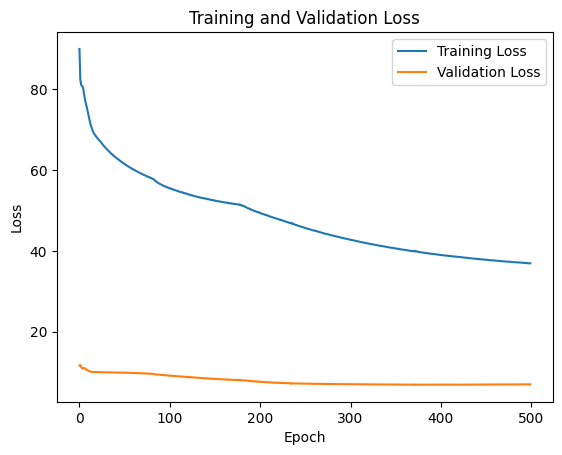

Model saved to models/gcn_1l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.13GB
Average Memory Usage: 2.75GB

Total Training Time: 4.93s
Max CPU Usage: 5.47GB
Max Memory Usage: 2.79GB


In [11]:
# Create model instances
gcn1_graph = GCN1Layer(num_features, num_classes)
print(gcn1_graph)
print(f"Total number of trainable parameters: {(gcn1_graph.count_parameters())*2}\n")
train_graph(gcn1_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcn_1l_graph.pth')

#### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 9604

Epoch 1, Train Loss: 89.83889925479889, Val Loss: 12.353306114673615
Time: 0.02s, CPU: 1.06GB, Memory: 2.77GB
Epoch 2, Train Loss: 79.84176152944565, Val Loss: 10.732541978359222
Time: 0.01s, CPU: 0.73GB, Memory: 2.77GB
Epoch 3, Train Loss: 81.59589850902557, Val Loss: 10.752568244934082
Time: 0.01s, CPU: 2.66GB, Memory: 2.77GB
Epoch 4, Train Loss: 78.51417148113251, Val Loss: 11.324703991413116
Time: 0.01s, CPU: 1.14GB, Memory: 2.77GB
Epoch 5, Train Loss: 75.04129660129547, Val Loss: 10.722905695438385
Time: 0.01s, CPU: 1.46GB, Memory: 2.77GB
Epoch 6, Train Loss: 73.51110011339188, Val Loss: 10.38305550813675
Time: 0.01s, CPU: 5.71GB, Memory: 2.77GB
Epoch 7, Train Loss: 71.43236666917801, Val Loss: 10.382747948169708
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 8, Train Loss: 68.66696453094482, Val Loss: 9.678365886211395

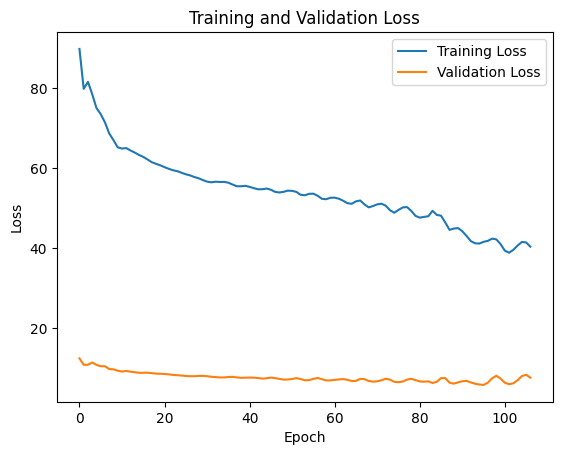

Model saved to models/gcn_2l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.24GB
Average Memory Usage: 2.78GB

Total Training Time: 1.16s
Max CPU Usage: 5.71GB
Max Memory Usage: 2.78GB


In [13]:
gcn2_graph = GCN2Layer(num_features, num_classes)
print(gcn2_graph)
print(f"Total number of trainable parameters: {(gcn2_graph.count_parameters())*2}\n")
train_graph(gcn2_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcn_2l_graph.pth')

### GCESN

#### Variant 1

##### Single Run

GCESN_var1(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Train Loss: 119.74495369195938, Val Loss: 10.139044225215912
Time: 0.02s, CPU: 1.30GB, Memory: 2.82GB
Epoch 2, Train Loss: 97.85032784938812, Val Loss: 9.534132778644562
Time: 0.01s, CPU: 2.00GB, Memory: 2.80GB
Epoch 3, Train Loss: 83.34139740467072, Val Loss: 9.51701134443283
Time: 0.01s, CPU: 1.34GB, Memory: 2.81GB
Epoch 4, Train Loss: 75.18326008319855, Val Loss: 9.854247272014618
Time: 0.01s, CPU: 2.00GB, Memory: 2.81GB
Epoch 5, Train Loss: 71.44840562343597, Val Loss: 10.275380909442902
Time: 0.01s, CPU: 2.91GB, Memory: 2.81GB
Epoch 6, Train Loss: 70.05715507268906, Val Loss: 10.58832585811615
Time: 0.01s, CPU: 2.29GB, Memory: 2.81GB
Epoch 7, Train Loss: 69.53275018930435, Val Loss: 10.720533728599548
Time: 0.01s, CPU: 1.14GB, Memory: 2.81GB
Epoch 8, Train Loss: 69.16446352005005, Val Loss: 10.690078139305115
Time: 0.01s, CPU: 2.40GB, Memory: 2.81GB
Epoch 9, Tr

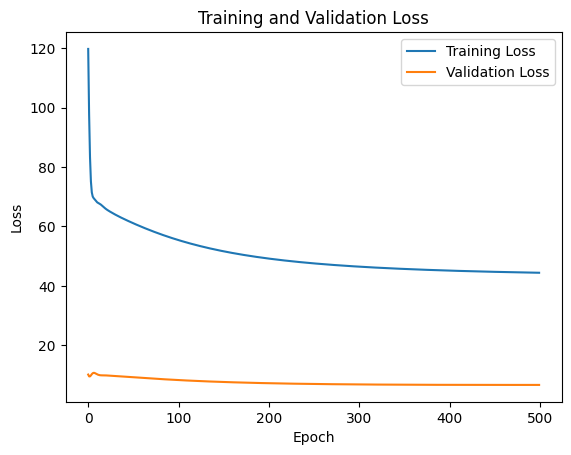

Model saved to models/gcesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.17GB
Average Memory Usage: 2.77GB

Total Training Time: 4.52s
Max CPU Usage: 4.46GB
Max Memory Usage: 2.82GB


In [15]:
# Create model instances
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
print(gcesn1_graph)
print(f"Total number of trainable parameters: {gcesn1_graph.count_parameters()}\n")
train_graph(gcesn1_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v1_graph.pth')

##### Multiple Run

In [29]:
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
train_and_evaluate_multiple_runs_graph(gcesn1_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcesn_v1_graph_')


Run 1/50 -> Loss: 51.482603788375854
  Total Training Time: 4.49s, Avg CPU Usage: 0.21GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 7.82GB, Max Memory Usage: 2.82GB
  Accuracy: 0.8421, Sensitivity: 0.8846, Specificity: 0.7500

Run 2/50 -> Loss: 51.449428021907806
  Total Training Time: 0.07s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.74GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.74GB
  Accuracy: 0.8421, Sensitivity: 0.8846, Specificity: 0.7500

Run 3/50 -> Loss: 51.38119238615036
  Total Training Time: 0.07s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.74GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.74GB
  Accuracy: 0.8684, Sensitivity: 0.8846, Specificity: 0.8333

Run 4/50 -> Loss: 51.3227843940258
  Total Training Time: 0.08s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.74GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.74GB
  Accuracy: 0.8684, Sensitivity: 0.8846, Specificity: 0.8333

Run 5/50 -> Loss: 51.268033266067505
  Total Training Time: 0.08s, Avg CPU Usage: 0.00GB, Avg Memo

#### Variant 2

##### Singe Run

GCESN_var2(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Train Loss: 5172.40106010437, Val Loss: 274.45587158203125
Time: 0.02s, CPU: 1.00GB, Memory: 2.84GB
Epoch 2, Train Loss: 2923.962410926819, Val Loss: 104.51897621154785
Time: 0.01s, CPU: 2.66GB, Memory: 2.82GB
Epoch 3, Train Loss: 733.4981346130371, Val Loss: 48.63921403884888
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 4, Train Loss: 385.3057818412781, Val Loss: 114.62782859802246
Time: 0.01s, CPU: 2.18GB, Memory: 2.82GB
Epoch 5, Train Loss: 605.157883644104, Val Loss: 127.19233989715576
Time: 0.01s, CPU: 1.14GB, Memory: 2.82GB
Epoch 6, Train Loss: 602.1519050598145, Val Loss: 106.25204801559448
Time: 0.01s, CPU: 2.66GB, Memory: 2.82GB
Epoch 7, Train Loss: 457.75565004348755, Val Loss: 63.60618352890015
Time: 0.01s, CPU: 3.20GB, Memory: 2.82GB
Epoch 8, Train Loss: 222.3627039194107, Val Loss: 12.251977622509003
Time: 0.01s, CPU: 1.34GB, Memory: 2.82GB
Epoch 9, T

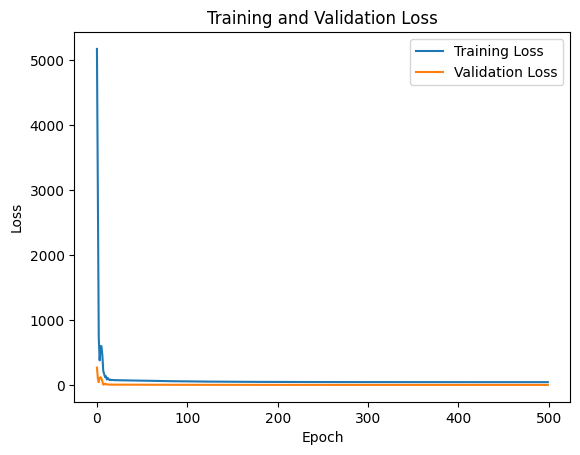

Model saved to models/gcesn_v2_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.19GB
Average Memory Usage: 2.76GB

Total Training Time: 4.78s
Max CPU Usage: 5.46GB
Max Memory Usage: 2.84GB


In [16]:
# Create model instances
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
print(gcesn2_graph)
print(f"Total number of trainable parameters: {gcesn2_graph.count_parameters()}\n")
train_graph(gcesn2_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v2_graph.pth')

##### Multiple Run

In [30]:
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
train_and_evaluate_multiple_runs_graph(gcesn2_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcesn_v2_graph_')


Run 1/50 -> Loss: 48.980287462472916
  Total Training Time: 4.70s, Avg CPU Usage: 0.19GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 7.78GB, Max Memory Usage: 2.84GB
  Accuracy: 0.8684, Sensitivity: 0.8846, Specificity: 0.8333

Run 2/50 -> Loss: 49.07308229804039
  Total Training Time: 0.08s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.76GB
  Accuracy: 0.8158, Sensitivity: 0.8846, Specificity: 0.6667

Run 3/50 -> Loss: 49.04491847753525
  Total Training Time: 0.08s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.76GB
  Accuracy: 0.8158, Sensitivity: 0.8846, Specificity: 0.6667

Run 4/50 -> Loss: 49.01336434483528
  Total Training Time: 0.08s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.76GB
  Accuracy: 0.8158, Sensitivity: 0.8846, Specificity: 0.6667

Run 5/50 -> Loss: 48.9620786011219
  Total Training Time: 0.10s, Avg CPU Usage: 0.00GB, Avg Memory

### GCN-ESN

#### Variant 1

##### Single Run

GCNESN_var1(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 642

Epoch 1, Train Loss: 85.6922373175621, Val Loss: 10.534148812294006
Time: 0.03s, CPU: 1.00GB, Memory: 2.84GB
Epoch 2, Train Loss: 83.47108399868011, Val Loss: 10.427325367927551
Time: 0.01s, CPU: 3.34GB, Memory: 2.84GB
Epoch 3, Train Loss: 78.97764873504639, Val Loss: 11.035561859607697
Time: 0.01s, CPU: 1.60GB, Memory: 2.84GB
Epoch 4, Train Loss: 75.0333241224289, Val Loss: 9.790491163730621
Time: 0.01s, CPU: 1.78GB, Memory: 2.84GB
Epoch 5, Train Loss: 74.93561285734177, Val Loss: 10.23613303899765
Time: 0.01s, CPU: 2.66GB, Memory: 2.84GB
Epoch 6, Train Loss: 71.79861497879028, Val Loss: 9.877511858940125
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 7, Train Loss: 71.50680333375931, Val Loss: 10.022903680801392
Time: 0.01s, CPU: 3.20GB, Memory: 2.84GB
Epoch 8, Train Loss: 70.3406308889389, Val Loss: 10.054178237915039
Time: 0.01s, CPU: 1.60GB, M

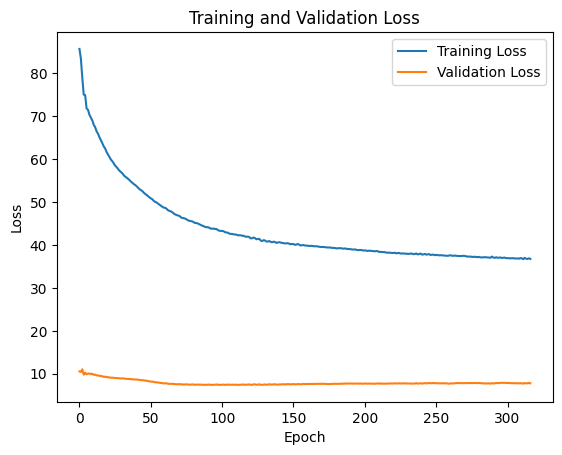

Model saved to models/gcnesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.26GB
Average Memory Usage: 2.76GB

Total Training Time: 3.62s
Max CPU Usage: 6.40GB
Max Memory Usage: 2.84GB


In [17]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
print(gcnesn1_graph)
print(f"Total number of trainable parameters: {gcnesn1_graph.count_parameters()}\n")
train_graph(gcnesn1_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcnesn_v1_graph.pth')

##### Multiple Run

In [31]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn1_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcnesn_v1_graph_')


Run 1/50 -> Loss: 40.02058753371239
  Total Training Time: 1.58s, Avg CPU Usage: 0.26GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 6.86GB, Max Memory Usage: 2.80GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 2/50 -> Loss: 38.603851929306984
  Total Training Time: 0.10s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.75GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.76GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 3/50 -> Loss: 37.61940445005894
  Total Training Time: 0.17s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.76GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 4/50 -> Loss: 37.366076931357384
  Total Training Time: 0.11s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.76GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 5/50 -> Loss: 37.45262958109379
  Total Training Time: 0.13s, Avg CPU Usage: 1.36GB, Avg Memo

#### Variant 2

##### Single Run

GCNESN_var2(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 4802

Epoch 1, Train Loss: 92.92878729104996, Val Loss: 10.144068002700806
Time: 0.03s, CPU: 1.39GB, Memory: 2.80GB
Epoch 2, Train Loss: 87.95624446868896, Val Loss: 10.722352266311646
Time: 0.01s, CPU: 1.46GB, Memory: 2.80GB
Epoch 3, Train Loss: 78.28745430707932, Val Loss: 11.135758459568024
Time: 0.01s, CPU: 2.18GB, Memory: 2.80GB
Epoch 4, Train Loss: 73.73991566896439, Val Loss: 9.135638773441315
Time: 0.01s, CPU: 2.18GB, Memory: 2.80GB
Epoch 5, Train Loss: 72.94591528177261, Val Loss: 10.190952122211456
Time: 0.01s, CPU: 2.18GB, Memory: 2.80GB
Epoch 6, Train Loss: 67.79795342683792, Val Loss: 8.89745146036148
Time: 0.01s, CPU: 2.18GB, Memory: 2.80GB
Epoch 7, Train Loss: 68.71756637096405, Val Loss: 9.388823211193085
Time: 0.01s, CPU: 3.08GB, Memory: 2.80GB
Epoch 8, Train Loss: 66.6890459060669, Val Loss: 9.368073642253876
T

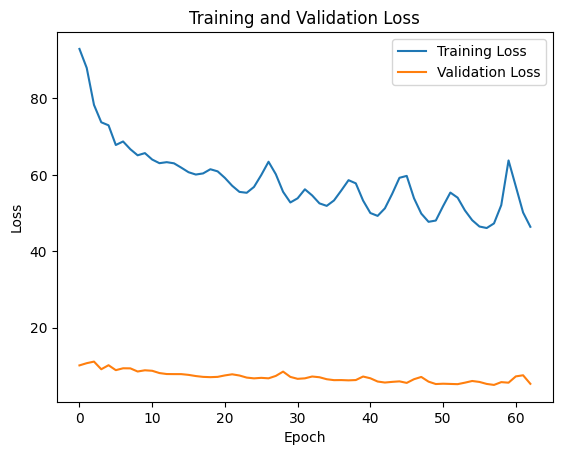

Model saved to models/gcnesn_v2_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.30GB
Average Memory Usage: 2.81GB

Total Training Time: 0.81s
Max CPU Usage: 3.08GB
Max Memory Usage: 2.82GB


In [18]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
print(gcnesn2_graph)
print(f"Total number of trainable parameters: {gcnesn2_graph.count_parameters()}\n")
train_graph(gcnesn2_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcnesn_v2_graph.pth')

##### Multiple Run

In [32]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn2_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcnesn_v2_graph_')


Run 1/50 -> Loss: 46.970199793577194
  Total Training Time: 0.70s, Avg CPU Usage: 0.22GB, Avg Memory Usage: 2.82GB, Max CPU Usage: 2.66GB, Max Memory Usage: 2.82GB
  Accuracy: 0.8421, Sensitivity: 0.8846, Specificity: 0.7500

Run 2/50 -> Loss: 41.34479132294655
  Total Training Time: 0.30s, Avg CPU Usage: 0.22GB, Avg Memory Usage: 2.82GB, Max CPU Usage: 2.02GB, Max Memory Usage: 2.84GB
  Accuracy: 0.8684, Sensitivity: 0.8846, Specificity: 0.8333

Run 3/50 -> Loss: 37.430934473872185
  Total Training Time: 0.46s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.84GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.84GB
  Accuracy: 0.8947, Sensitivity: 0.9615, Specificity: 0.7500

Run 4/50 -> Loss: 36.2027635499835
  Total Training Time: 0.64s, Avg CPU Usage: 0.31GB, Avg Memory Usage: 2.83GB, Max CPU Usage: 3.34GB, Max Memory Usage: 2.84GB
  Accuracy: 0.8947, Sensitivity: 0.9615, Specificity: 0.7500

Run 5/50 -> Loss: 32.710556246340275
  Total Training Time: 0.74s, Avg CPU Usage: 0.13GB, Avg Memo

## Evaluation

In [19]:
print('Model 1-Layer GCN')
gcn1_graph = GCN1Layer(num_features, num_classes)
gcn1_graph.load_state_dict(torch.load('models/gcn_1l_graph.pth'))
test_graph(gcn1_graph, mutag_test_loader)

print('\nModel 2-Layer GCN')
gcn2_graph = GCN2Layer(num_features, num_classes)
gcn2_graph.load_state_dict(torch.load('models/gcn_2l_graph.pth'))
test_graph(gcn2_graph, mutag_test_loader)

print('\nModel GCESN Var-1')
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
gcesn1_graph.load_state_dict(torch.load('models/gcesn_v1_graph.pth'))
test_graph(gcesn1_graph, mutag_test_loader)

print('\nModel GCESN Var-2')
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
gcesn2_graph.load_state_dict(torch.load('models/gcesn_v2_graph.pth'))
test_graph(gcesn2_graph, mutag_test_loader)

print('\nModel GCNESN Var-1')
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
gcnesn1_graph.load_state_dict(torch.load('models/gcnesn_v1_graph.pth'))
test_graph(gcnesn1_graph, mutag_test_loader)

print('\nModel GCNESN Var-2')
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
gcnesn2_graph.load_state_dict(torch.load('models/gcnesn_v2_graph.pth'))
test_graph(gcnesn2_graph, mutag_test_loader)

Model 1-Layer GCN
Accuracy: 0.9211
Sensitivity: 0.9231
Specificity: 0.9167

Model 2-Layer GCN
Accuracy: 0.9211
Sensitivity: 0.9231
Specificity: 0.9167

Model GCESN Var-1
Accuracy: 0.9474
Sensitivity: 0.9231
Specificity: 1.0000

Model GCESN Var-2
Accuracy: 0.8684
Sensitivity: 0.8846
Specificity: 0.8333

Model GCNESN Var-1
Accuracy: 0.9474
Sensitivity: 0.9615
Specificity: 0.9167

Model GCNESN Var-2
Accuracy: 0.8947
Sensitivity: 0.8846
Specificity: 0.9167


In [33]:
def measure_inference_performance(model, loader):
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)

            start_time = time.time()
            cpu_start = psutil.cpu_percent(interval=None)
            mem_start = psutil.virtual_memory().used

            output = model(x, adj_matrix, batch)

            cpu_end = psutil.cpu_percent(interval=None)
            mem_end = psutil.virtual_memory().used
            end_time = time.time()

            inference_times.append(end_time - start_time)
            cpu_usages.append((cpu_end - cpu_start) / 100 * psutil.virtual_memory().total / (1024**2))
            memory_usages.append((mem_end - mem_start) / (1024*2))

    avg_inference_time = np.mean(inference_times)
    avg_cpu_usage = np.mean(cpu_usages)
    avg_memory_usage = np.mean(memory_usages)

    print(f'Average Inference Time: {avg_inference_time:.6f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.6f}KB')
    print(f'Average Memory Usage: {avg_memory_usage:.6f}KB')

    return

In [39]:
print('\nInference 1-Layer GCN:')
measure_inference_performance(gcn1_graph, mutag_test_loader)

print('\nInference 2-Layer GCN:')
measure_inference_performance(gcn2_graph, mutag_test_loader)

print('\nInference GCESN Var-1:')
measure_inference_performance(gcesn1_graph, mutag_test_loader)

print('\nInference GCESN Var-2:')
measure_inference_performance(gcesn2_graph, mutag_test_loader)

print('\nInference GCNESN Var-1:')
measure_inference_performance(gcnesn1_graph, mutag_test_loader)

print('\nInference GCNESN Var-2:')
measure_inference_performance(gcnesn2_graph, mutag_test_loader)


Inference 1-Layer GCN:
Average Inference Time: 0.000340s
Average CPU Usage: 3731.456000KB
Average Memory Usage: 4.000000KB

Inference 2-Layer GCN:
Average Inference Time: 0.000379s
Average CPU Usage: 0.000000KB
Average Memory Usage: 140.000000KB

Inference GCESN Var-1:
Average Inference Time: 0.000440s
Average CPU Usage: 0.000000KB
Average Memory Usage: 0.000000KB

Inference GCESN Var-2:
Average Inference Time: 0.000742s
Average CPU Usage: 0.000000KB
Average Memory Usage: 0.000000KB

Inference GCNESN Var-1:
Average Inference Time: 0.000424s
Average CPU Usage: 0.000000KB
Average Memory Usage: 0.000000KB

Inference GCNESN Var-2:
Average Inference Time: 0.000641s
Average CPU Usage: 0.000000KB
Average Memory Usage: 0.000000KB


# Node Classification

In [46]:
# Load the Cora dataset
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = cora_dataset[0]

# Example of data attributes
print(cora_data)
print("Node feature shape:", cora_data.x.shape)
print("Edge index shape:", cora_data.edge_index.shape)
print("Number of classes:", cora_dataset.num_classes)
print("Number of node features:", cora_dataset.num_node_features)

# Splitting the data into train, validation, and test sets
train_mask = cora_data.train_mask
val_mask = cora_data.val_mask
test_mask = cora_data.test_mask


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Number of classes: 7
Number of node features: 1433


Processing...
Done!


In [47]:
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(cora_data)
print(f'Cora dataset - Longest path: {longest_path}')
print(f'Cora dataset - Shortest path: {shortest_path}')
print(f'Cora dataset - Overall average path: {overall_average_path:.2f}')
print(f'Cora dataset - Standard deviation of average paths: {std_average_path:.2f}')

Cora dataset - Longest path: 19
Cora dataset - Shortest path: 0
Cora dataset - Overall average path: 6.31
Cora dataset - Standard deviation of average paths: 0.00


## Model Definition

### Models

#### GCN

In [48]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        # print(f'x shape: {x.shape}, adj shape: {adj.shape}')
        x = F.relu(self.gcn1(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.gcn2 = GCN(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCESN

In [49]:
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCN-ESN

In [50]:
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [84]:
def train_node(model, data, lr=0.001, num_epochs=100, patience=10, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)  # Convert edge_index to adjacency matrix

    for epoch in range(num_epochs):
        epoch_loss = 0
        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        optimizer.zero_grad()
        output = model(data.x, adj_matrix)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            val_output = model(data.x, adj_matrix)
            val_loss = criterion(val_output[data.val_mask], data.y[data.val_mask]).item()

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch+1
            # torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                # print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch+1
                break

        # print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        # print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    # # Plot the training and validation loss
    # plt.plot(training_loss, label='Training Loss')
    # plt.plot(validation_loss, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss')
    # plt.legend()
    # plt.show()

    # # Load the best model
    # model.load_state_dict(torch.load(save_path))
    # print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    # print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    # print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    # print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    # print(f'\nTotal Training Time: {total_training_time:.2f}s')
    # print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    # print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    # return
    return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage, total_epoch  

def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity

def test_node(model, data, mask):
    model.eval()
    y_true = data.y[mask].tolist()
    y_pred = []

    with torch.no_grad():
        adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)
        output = model(data.x, adj_matrix)
        pred = output[mask].argmax(dim=1)
        y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return 
    # return accuracy, sensitivity, specificity

In [78]:
def train_and_evaluate_multiple_runs_node(model, data, num_runs=50, num_epochs=100, path='models/multiple_run/gcesn_v1_node_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []
    all_epoch = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory, total_epoch = train_node(model, data, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_node(model, cora_data, cora_data.val_mask)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)
        all_epoch.append(total_epoch)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    avg_num_epoch = np.mean(all_epoch)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Num Epoch:{avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

## Training

### GCN

#### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Train Loss: 2.286627769470215, Val Loss: 2.060330629348755
Time: 0.02s, CPU: 1.62GB, Memory: 2.80GB
Epoch 2, Train Loss: 1.9065699577331543, Val Loss: 1.9661865234375
Time: 0.01s, CPU: 1.60GB, Memory: 2.79GB
Epoch 3, Train Loss: 1.67721688747406, Val Loss: 1.8920868635177612
Time: 0.01s, CPU: 4.00GB, Memory: 2.78GB
Epoch 4, Train Loss: 1.5118333101272583, Val Loss: 1.8312451839447021
Time: 0.01s, CPU: 1.46GB, Memory: 2.78GB
Epoch 5, Train Loss: 1.3828527927398682, Val Loss: 1.7719781398773193
Time: 0.01s, CPU: 0.00GB, Memory: 2.78GB
Epoch 6, Train Loss: 1.261491298675537, Val Loss: 1.7149208784103394
Time: 0.01s, CPU: 0.00GB, Memory: 2.78GB
Epoch 7, Train Loss: 1.146529197692871, Val Loss: 1.6548243761062622
Time: 0.01s, CPU: 0.00GB, Memory: 2.78GB
Epoch 8, Train Loss: 1.0404704809188843, Val Loss: 1.59288489818573
Time: 0.01s, CPU: 0.0

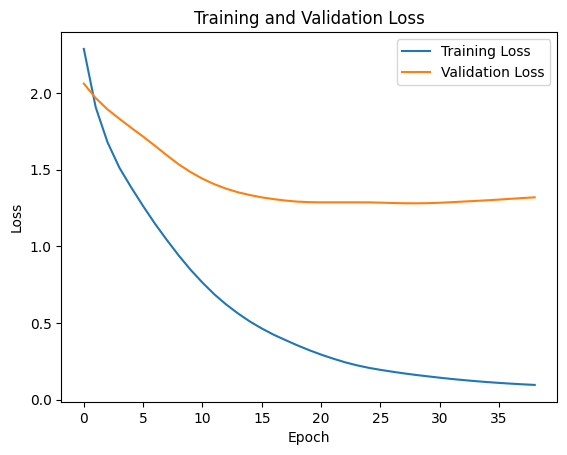

Model saved to models/gcn_1l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.22GB
Average Memory Usage: 2.78GB

Total Training Time: 0.34s
Max CPU Usage: 4.00GB
Max Memory Usage: 2.80GB


In [54]:
# Create model instances
gcn1_node = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(gcn1_node)
print(f"Total number of trainable parameters: {gcn1_node.count_parameters()}\n")
train_node(gcn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_1l_node.pth')


#### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Train Loss: 3.7939679622650146, Val Loss: 1.9179457426071167
Time: 0.09s, CPU: 1.77GB, Memory: 2.82GB
Epoch 2, Train Loss: 2.5998010635375977, Val Loss: 1.911553978919983
Time: 0.04s, CPU: 5.66GB, Memory: 2.83GB
Epoch 3, Train Loss: 2.189985513687134, Val Loss: 1.8619734048843384
Time: 0.03s, CPU: 0.00GB, Memory: 2.81GB
Epoch 4, Train Loss: 1.964756965637207, Val Loss: 1.826151728630066
Time: 0.02s, CPU: 0.00GB, Memory: 2.81GB
Epoch 5, Train Loss: 1.7606745958328247, Val Loss: 1.789262056350708
Time: 0.02s, CPU: 0.00GB, Memory: 2.81GB
Epoch 6, Train Loss: 1.6393909454345703, Val Loss: 1.7657700777053833
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 7, Train Loss: 1.5808825492858887, Val Loss: 1.7448158264160156
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 8, Train Loss: 1.5417717695236206, Val Loss: 1.7129913

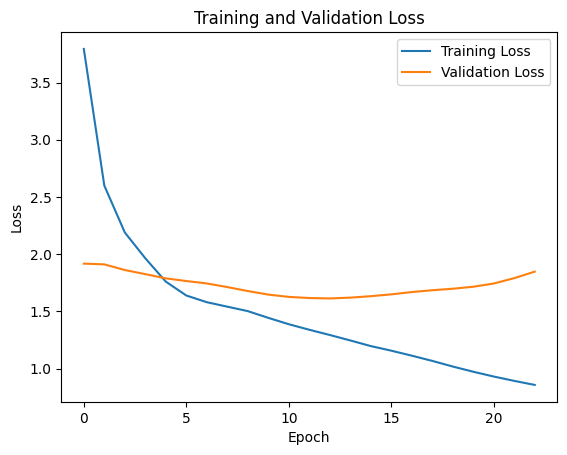

Model saved to models/gcn_2l_node.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 0.32GB
Average Memory Usage: 2.81GB

Total Training Time: 0.51s
Max CPU Usage: 5.66GB
Max Memory Usage: 2.83GB


In [55]:
gcn2_node = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(gcn2_node)
print(f"Total number of trainable parameters: {gcn2_node.count_parameters()}\n")
train_node(gcn2_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_2l_node.pth')

### GCESN

#### Variant 1

##### Single Run

GCESN_var1(
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 10038

Epoch 1, Train Loss: 4.440561771392822, Val Loss: 4.74982213973999
Time: 0.16s, CPU: 1.46GB, Memory: 2.88GB
Epoch 2, Train Loss: 5.486979961395264, Val Loss: 16.247295379638672
Time: 0.15s, CPU: 2.46GB, Memory: 2.88GB
Epoch 3, Train Loss: 13.739534378051758, Val Loss: 20.38908576965332
Time: 0.15s, CPU: 2.66GB, Memory: 2.87GB
Epoch 4, Train Loss: 16.88147735595703, Val Loss: 20.84930419921875
Time: 0.15s, CPU: 2.47GB, Memory: 2.87GB
Epoch 5, Train Loss: 18.30681610107422, Val Loss: 17.689401626586914
Time: 0.15s, CPU: 2.31GB, Memory: 2.89GB
Epoch 6, Train Loss: 16.426950454711914, Val Loss: 13.21545696258545
Time: 0.15s, CPU: 2.21GB, Memory: 2.87GB
Epoch 7, Train Loss: 13.537982940673828, Val Loss: 10.217391014099121
Time: 0.15s, CPU: 2.66GB, Memory: 2.86GB
Epoch 8, Train Loss: 11.303751945495605, Val Loss: 10.406953811645508
Time: 0.15s, CPU: 1.86GB, Memory: 2.87GB
Ep

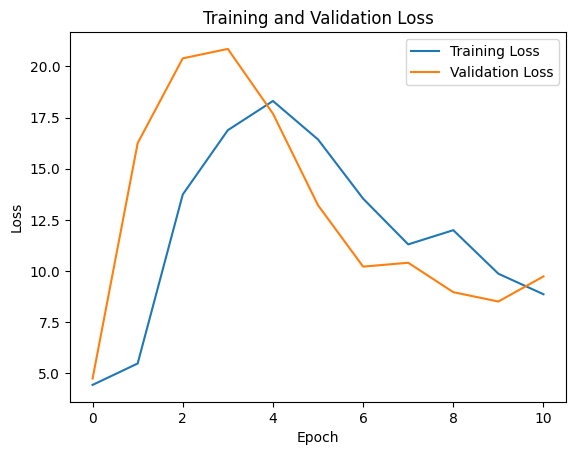

Model saved to models/gcesn_v1_node.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 2.23GB
Average Memory Usage: 2.87GB

Total Training Time: 1.66s
Max CPU Usage: 2.66GB
Max Memory Usage: 2.89GB


In [56]:
# Create model instances
num_features = cora_dataset.num_node_features
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
print(gcesn1_node)
print(f"Total number of trainable parameters: {gcesn1_node.count_parameters()}\n")
train_node(gcesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcesn_v1_node.pth')

##### Multiple Runs

In [79]:
num_features = cora_dataset.num_node_features
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
train_and_evaluate_multiple_runs_node(gcesn1_node, cora_data, path='models/multiple_run/gcesn_v1_node.pth')


Run 1/50 -> Loss: 0.10364343971014023
  Total Training Time: 15.19s, Avg CPU Usage: 2.12GB, Avg Memory Usage: 2.66GB, Max CPU Usage: 3.41GB, Max Memory Usage: 2.71GB
  Accuracy: 0.9718, Sensitivity: 0.9394, Specificity: 1.0000

Run 2/50 -> Loss: 0.03862113878130913
  Total Training Time: 15.47s, Avg CPU Usage: 2.25GB, Avg Memory Usage: 2.64GB, Max CPU Usage: 4.63GB, Max Memory Usage: 2.71GB
  Accuracy: 0.9710, Sensitivity: 0.9394, Specificity: 1.0000

Run 3/50 -> Loss: 0.23625482618808746
  Total Training Time: 3.36s, Avg CPU Usage: 2.50GB, Avg Memory Usage: 2.62GB, Max CPU Usage: 5.36GB, Max Memory Usage: 2.68GB
  Accuracy: 0.9836, Sensitivity: 0.9667, Specificity: 1.0000

Run 4/50 -> Loss: 0.010877719148993492
  Total Training Time: 15.22s, Avg CPU Usage: 2.28GB, Avg Memory Usage: 2.65GB, Max CPU Usage: 5.33GB, Max Memory Usage: 2.72GB
  Accuracy: 0.9855, Sensitivity: 0.9688, Specificity: 1.0000

Run 5/50 -> Loss: 0.003018466755747795
  Total Training Time: 15.80s, Avg CPU Usage: 2.

#### Variant 2

##### Single Run

GCESN_var2(
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 10038

Epoch 1, Train Loss: 5.486979961395264, Val Loss: 17.85521125793457
Time: 0.17s, CPU: 1.76GB, Memory: 2.81GB
Epoch 2, Train Loss: 13.733979225158691, Val Loss: 20.805391311645508
Time: 0.15s, CPU: 2.38GB, Memory: 2.80GB
Epoch 3, Train Loss: 15.574593544006348, Val Loss: 21.757673263549805
Time: 0.16s, CPU: 3.25GB, Memory: 2.80GB
Epoch 4, Train Loss: 16.963943481445312, Val Loss: 21.114906311035156
Time: 0.15s, CPU: 0.00GB, Memory: 2.82GB
Epoch 5, Train Loss: 17.044198989868164, Val Loss: 13.44571304321289
Time: 0.15s, CPU: 2.25GB, Memory: 2.85GB
Epoch 6, Train Loss: 9.572219848632812, Val Loss: 11.446514129638672
Time: 0.15s, CPU: 2.71GB, Memory: 2.85GB
Epoch 7, Train Loss: 9.056180953979492, Val Loss: 6.168360710144043
Time: 0.15s, CPU: 2.38GB, Memory: 2.83GB
Epoch 8, Train Loss: 5.454814910888672, Val Loss: 8.351069450378418
Time: 0.15s, CPU: 2.08GB, Memory: 2.86GB
E

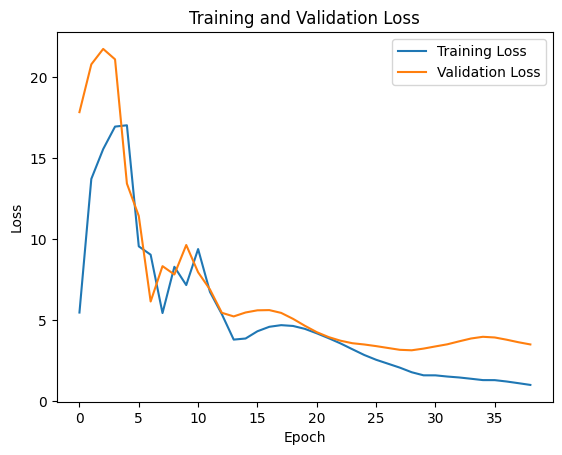

Model saved to models/gcesn_v2_node.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 2.40GB
Average Memory Usage: 2.83GB

Total Training Time: 6.16s
Max CPU Usage: 5.58GB
Max Memory Usage: 2.88GB


In [57]:
# Create model instances
num_features = cora_dataset.num_node_features
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
print(gcesn2_node)
print(f"Total number of trainable parameters: {gcesn2_node.count_parameters()}\n")
train_node(gcesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcesn_v2_node.pth')

##### Multiple Runs

In [80]:
num_features = cora_dataset.num_node_features
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
train_and_evaluate_multiple_runs_node(gcesn2_node, cora_data, path='models/multiple_run/gcesn_v2_node.pth')


Run 1/50 -> Loss: 0.04129861667752266
  Total Training Time: 20.36s, Avg CPU Usage: 2.47GB, Avg Memory Usage: 2.67GB, Max CPU Usage: 4.06GB, Max Memory Usage: 2.76GB
  Accuracy: 0.9863, Sensitivity: 0.9706, Specificity: 1.0000

Run 2/50 -> Loss: 0.3761378228664398
  Total Training Time: 6.12s, Avg CPU Usage: 3.04GB, Avg Memory Usage: 2.73GB, Max CPU Usage: 5.62GB, Max Memory Usage: 2.81GB
  Accuracy: 0.9844, Sensitivity: 0.9677, Specificity: 1.0000

Run 3/50 -> Loss: 0.4319148063659668
  Total Training Time: 4.94s, Avg CPU Usage: 2.37GB, Avg Memory Usage: 2.79GB, Max CPU Usage: 3.50GB, Max Memory Usage: 2.83GB
  Accuracy: 0.9219, Sensitivity: 1.0000, Specificity: 0.8387

Run 4/50 -> Loss: 0.0027755035553127527
  Total Training Time: 9.05s, Avg CPU Usage: 2.40GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 3.98GB, Max Memory Usage: 2.82GB
  Accuracy: 1.0000, Sensitivity: 1.0000, Specificity: 1.0000

Run 5/50 -> Loss: 0.0007518562488257885
  Total Training Time: 3.09s, Avg CPU Usage: 2.67G

### GCN-ESN

#### Variant 1

##### Single Run

GCNESN_var1(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Train Loss: 2.1662473678588867, Val Loss: 1.9906768798828125
Time: 0.05s, CPU: 1.54GB, Memory: 2.86GB
Epoch 2, Train Loss: 1.8308634757995605, Val Loss: 1.8946229219436646
Time: 0.01s, CPU: 1.41GB, Memory: 2.86GB
Epoch 3, Train Loss: 1.6045830249786377, Val Loss: 1.811041235923767
Time: 0.01s, CPU: 0.80GB, Memory: 2.86GB
Epoch 4, Train Loss: 1.4235625267028809, Val Loss: 1.7302359342575073
Time: 0.01s, CPU: 2.46GB, Memory: 2.86GB
Epoch 5, Train Loss: 1.258113145828247, Val Loss: 1.6487070322036743
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 6, Train Loss: 1.0968700647354126, Val Loss: 1.562949299812317
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 7, Train Loss: 0.9460855722427368, Val Loss: 1.4765222072601318
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 8, Train Loss: 0.8081862330436707, Val Loss: 1.3926759958267212
Time: 0.01s

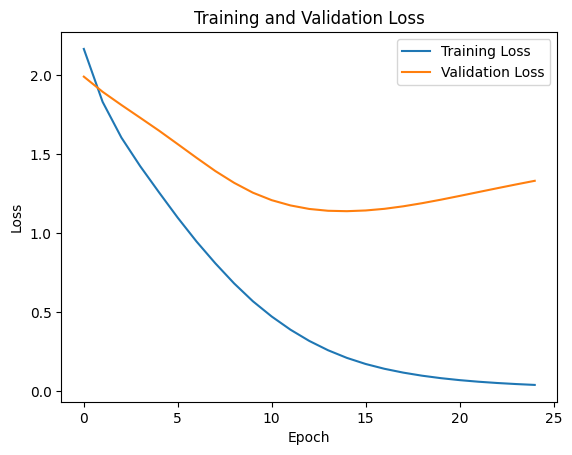

Model saved to models/gcnesn_v1_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.25GB
Average Memory Usage: 2.86GB

Total Training Time: 0.26s
Max CPU Usage: 2.46GB
Max Memory Usage: 2.86GB


In [58]:
# Create model instances
num_features = cora_dataset.num_node_features
gcnesn1_node = GCNESN_var1(num_features, 16, cora_dataset.num_classes)
print(gcnesn1_node)
print(f"Total number of trainable parameters: {gcnesn1_node.count_parameters()}\n")
train_node(gcnesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcnesn_v1_node.pth')

##### Multiple Run

In [81]:
num_features = cora_dataset.num_node_features
gcnesn1_node = GCNESN_var1(num_features, 16, cora_dataset.num_classes)
train_and_evaluate_multiple_runs_node(gcnesn1_node, cora_data, path='models/multiple_run/gcnesn_v1_node.pth')


Run 1/50 -> Loss: 0.0008988881600089371
  Total Training Time: 1.72s, Avg CPU Usage: 1.04GB, Avg Memory Usage: 2.80GB, Max CPU Usage: 7.62GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9559, Sensitivity: 0.9643, Specificity: 0.9500

Run 2/50 -> Loss: 9.936619562722626e-07
  Total Training Time: 1.37s, Avg CPU Usage: 0.50GB, Avg Memory Usage: 2.80GB, Max CPU Usage: 4.99GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9565, Sensitivity: 0.9655, Specificity: 0.9500

Run 3/50 -> Loss: 8.514948746096707e-10
  Total Training Time: 0.43s, Avg CPU Usage: 0.48GB, Avg Memory Usage: 2.80GB, Max CPU Usage: 3.70GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9437, Sensitivity: 0.9333, Specificity: 0.9512

Run 4/50 -> Loss: 8.514948746096707e-10
  Total Training Time: 0.12s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.79GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.79GB
  Accuracy: 0.9437, Sensitivity: 0.9333, Specificity: 0.9512

Run 5/50 -> Loss: 0.0
  Total Training Time: 0.14s, Avg CPU Usage: 0.00GB, Avg Memo

#### Variant 2

##### Single Run

GCNESN_var2(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Train Loss: 2.4841320514678955, Val Loss: 1.934669852256775
Time: 0.04s, CPU: 1.84GB, Memory: 2.84GB
Epoch 2, Train Loss: 1.943387508392334, Val Loss: 1.8874341249465942
Time: 0.01s, CPU: 1.78GB, Memory: 2.84GB
Epoch 3, Train Loss: 1.79638671875, Val Loss: 1.8385834693908691
Time: 0.02s, CPU: 2.14GB, Memory: 2.84GB
Epoch 4, Train Loss: 1.6717207431793213, Val Loss: 1.8106470108032227
Time: 0.01s, CPU: 3.50GB, Memory: 2.84GB
Epoch 5, Train Loss: 1.5944428443908691, Val Loss: 1.7873601913452148
Time: 0.01s, CPU: 3.11GB, Memory: 2.84GB
Epoch 6, Train Loss: 1.5292104482650757, Val Loss: 1.7580199241638184
Time: 0.01s, CPU: 2.50GB, Memory: 2.84GB
Epoch 7, Train Loss: 1.4588896036148071, Val Loss: 1.7264924049377441
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 8, Train Loss: 1.3918991088867188, Val Loss: 1.6745417

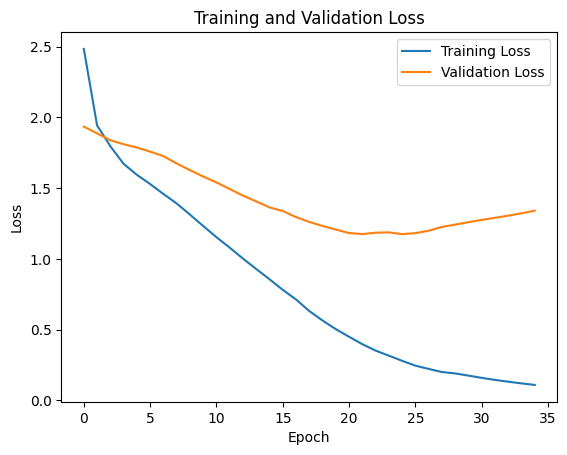

Model saved to models/gcnesn_v2_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.42GB
Average Memory Usage: 2.84GB

Total Training Time: 0.51s
Max CPU Usage: 3.50GB
Max Memory Usage: 2.84GB


In [59]:
# Create model instances
num_features = cora_dataset.num_node_features
gcnesn2_node = GCNESN_var2(num_features, 16, cora_dataset.num_classes)
print(gcnesn2_node)
print(f"Total number of trainable parameters: {gcnesn2_node.count_parameters()}\n")
train_node(gcnesn2_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcnesn_v2_node.pth')

##### Multiple Run

In [82]:
num_features = cora_dataset.num_node_features
gcnesn2_node = GCNESN_var2(num_features, num_features, cora_dataset.num_classes)
train_and_evaluate_multiple_runs_node(gcnesn2_node, cora_data, path='models/multiple_run/gcnesn_v2_node.pth')


Run 1/50 -> Loss: 0.0005768310511484742
  Total Training Time: 31.97s, Avg CPU Usage: 2.25GB, Avg Memory Usage: 2.72GB, Max CPU Usage: 3.80GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9851, Sensitivity: 1.0000, Specificity: 0.9722

Run 2/50 -> Loss: 0.0019441951299086213
  Total Training Time: 7.26s, Avg CPU Usage: 2.81GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 5.46GB, Max Memory Usage: 2.99GB
  Accuracy: 0.9710, Sensitivity: 0.9630, Specificity: 0.9762

Run 3/50 -> Loss: 2.9621585781569593e-05
  Total Training Time: 15.79s, Avg CPU Usage: 2.50GB, Avg Memory Usage: 2.90GB, Max CPU Usage: 4.92GB, Max Memory Usage: 2.94GB
  Accuracy: 0.9868, Sensitivity: 1.0000, Specificity: 0.9787

Run 4/50 -> Loss: 0.003227346111088991
  Total Training Time: 5.26s, Avg CPU Usage: 2.17GB, Avg Memory Usage: 2.90GB, Max CPU Usage: 2.81GB, Max Memory Usage: 2.95GB
  Accuracy: 0.9859, Sensitivity: 1.0000, Specificity: 0.9756

Run 5/50 -> Loss: 0.0001298069691983983
  Total Training Time: 5.28s, Avg CPU Usa

## Evaluation

In [85]:
print('Model 1-Layer GCN')
gcn1_node = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
gcn1_node.load_state_dict(torch.load('models/gcn_1l_node.pth'))
test_node(gcn1_node, cora_data, cora_data.test_mask)

print('\nModel 2-Layer GCN')
gcn2_node = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
gcn2_node.load_state_dict(torch.load('models/gcn_2l_node.pth'))
test_node(gcn2_node, cora_data, cora_data.test_mask)

num_features = cora_dataset.num_node_features
print('\nModel GCESN Var-1')
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
gcesn1_node.load_state_dict(torch.load('models/gcesn_v1_node.pth'))
test_node(gcesn1_node, cora_data, cora_data.test_mask)

print('\nModel GCESN Var-2')
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
gcesn2_node.load_state_dict(torch.load('models/gcesn_v2_node.pth'))
test_node(gcesn2_node, cora_data, cora_data.test_mask)

print('\nModel GCN-ESN Var-1')
gcnesn1_node = GCNESN_var1(num_features, 16, cora_dataset.num_classes)
gcnesn1_node.load_state_dict(torch.load('models/gcnesn_v1_node.pth'))
test_node(gcnesn1_node, cora_data, cora_data.test_mask)

print('\nModel GCN-ESN Var-2')
gcnesn2_node = GCNESN_var2(num_features, 16, cora_dataset.num_classes)
gcnesn2_node.load_state_dict(torch.load('models/gcnesn_v2_node.pth'))
test_node(gcnesn2_node, cora_data, cora_data.test_mask)

Model 1-Layer GCN
Accuracy: 0.8361
Sensitivity: 0.6582
Specificity: 0.9712

Model 2-Layer GCN
Accuracy: 0.8418
Sensitivity: 0.8590
Specificity: 0.8250

Model GCESN Var-1
Accuracy: 0.8364
Sensitivity: 1.0000
Specificity: 0.7568

Model GCESN Var-2
Accuracy: 0.9541
Sensitivity: 0.9434
Specificity: 0.9643

Model GCN-ESN Var-1
Accuracy: 0.9267
Sensitivity: 0.8871
Specificity: 0.9545

Model GCN-ESN Var-2
Accuracy: 0.9565
Sensitivity: 0.9730
Specificity: 0.9375


In [91]:
def measure_inference_performance(model, data, mask):
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)

        start_time = time.time()
        cpu_start = psutil.cpu_percent(interval=None)
        mem_start = psutil.virtual_memory().used

        output = model(x, adj_matrix)

        cpu_end = psutil.cpu_percent(interval=None)
        mem_end = psutil.virtual_memory().used
        end_time = time.time()

        inference_times.append(end_time - start_time)
        cpu_usages.append((cpu_end - cpu_start) / 100 * psutil.virtual_memory().total / (1024**2))
        memory_usages.append((mem_end - mem_start) / (1024**1))

    avg_inference_time = np.mean(inference_times)
    avg_cpu_usage = np.mean(cpu_usages)
    avg_memory_usage = np.mean(memory_usages)

    print(f'Average Inference Time: {avg_inference_time:.6f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.6f}MB')
    print(f'Average Memory Usage: {avg_memory_usage:.6f}KB')

    return
    # return avg_inference_time, avg_cpu_usage, avg_memory_usage

In [110]:
print('\nInference 1-Layer GCN:')
measure_inference_performance(gcn1_node, cora_data, cora_data.test_mask)

print('\nInference 2-Layer GCN:')
measure_inference_performance(gcn2_node, cora_data, cora_data.test_mask)

print('\nInference GCESN Var-1:')
measure_inference_performance(gcesn1_node, cora_data, cora_data.test_mask)

print('\nInference GCESN Var-2:')
measure_inference_performance(gcesn2_node, cora_data, cora_data.test_mask)

print('\nInference GCNESN Var-1:')
measure_inference_performance(gcnesn1_node, cora_data, cora_data.test_mask)

print('\nInference GCNESN Var-2:')
measure_inference_performance(gcnesn2_node, cora_data, cora_data.test_mask)


Inference 1-Layer GCN:
Average Inference Time: 0.005256s
Average CPU Usage: 745.472000MB
Average Memory Usage: 2784.000000MB

Inference 2-Layer GCN:
Average Inference Time: 0.123237s
Average CPU Usage: 0.000000MB
Average Memory Usage: 25600.000000MB

Inference GCESN Var-1:
Average Inference Time: 0.300374s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-2:
Average Inference Time: 0.239370s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-1:
Average Inference Time: 0.004671s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-2:
Average Inference Time: 0.007516s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB
